This notebook was created as part of the Master project: 'Safe and Sustainable by design: environmental fate of phosphorus compounds'. 

By Hannah Flerlage, University of Amsterdam, January-December 2020. 
Email: hannah.flerlage@posteo.de

This is the 3. of 3 notebooks for the systematic, computer-aided approach to redesigning chemicals developed in the project.


# 3. Multi-property based selection: Desirability functions

## Packages

In [60]:
import os
import subprocess
import pandas as pd
import numpy as np
import math
from math import log10
import time
from itertools import groupby
from IPython.display import Image
from functools import reduce

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors

from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Draw.MolDrawing import DrawingOptions
DrawingOptions.includeAtomNumbers=True
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

from scipy.interpolate import interp1d


## Functions

In [61]:
def show_mol_grid(mols):
    '''draws molecules in grid, needs to be last command in cell'''
    return MolsToGridImage(mols
        , subImgSize=(250,200)
        ,molsPerRow=3
    )

def drawsmileslist(smileslist):
    '''draws molecules from list of smiles in grid, needs to be last command in cell'''
    mols = []
    for smiles in smileslist:
        mols.append(Chem.MolFromSmiles(smiles))
    return(show_mol_grid(mols))

##### filter out subgroup containing mols#############

def smilestomollist(smileslist):
    mollist = []
    for smiles in smileslist:
        mol = Chem.MolFromSmiles(smiles)
        mollist.append(mol)
    return(mollist)

OHsmarts = '[OX2H]'
Nsmarts = '[N]'
Ethersmarts = '[OD2]([#6])[#6]'
Aldehydesmarts = '[CX3H1](=O)[#6]'
Enolsmarts = '[OX2H][#6X3]=[#6]'

def filteroutSmartsbool(mollist, Smarts):
    '''input list of rd-mols! Filters out molecules with specified smarts code'''
    pattern = Chem.MolFromSmarts(Smarts)
    molsfiltered = 0
    newlist = []
    for mol in mollist:
        if mol.HasSubstructMatch(pattern):
            molsfiltered += 1
            newlist.append(False)
        else:
            newlist.append(True)
    print(molsfiltered,'structures with specified substructure (smarts) were filtered out.')
    return(newlist)

def filterinSmartsbool(mollist, Smarts):
    '''input list of rd-mols! Filters molecules with specified smarts code'''
    pattern = Chem.MolFromSmarts(Smarts)
    molsfiltered = 0
    newlist = []
    for mol in mollist:
        if mol.HasSubstructMatch(pattern):
            molsfiltered += 1
            newlist.append(True)
        else:
            newlist.append(False)
    print(molsfiltered,'structures with specified substructure (smarts) were selected.')
    return(newlist)
    
    
def filteroutSmartsdf(dfin, smarts):
    '''returns new df with molecules from df without OH-groups'''
    df = dfin[filteroutSmartsbool(smilestomollist(dfin['SMILES']),smarts)]
    df.dropna
    print('Molecules without specified group in new DataFrame: ', len(df.index))
    if df.empty:
        print('DataFrame is empty, all molecules contained group')
    else:
        return(df)
    
def filterinSmartsdf(dfin, smarts):
    '''returns new df with molecules from df without OH-groups'''
    df = dfin[filterinSmartsbool(smilestomollist(dfin['SMILES']),smarts)]
    df.dropna
    print('Molecules without specified group filtered out: ', len(dfin.index) - len(df.index))
    if df.empty:
        print('DataFrame is empty, no molecules contained group')
    else:
        return(df)


## Import BigDF: all ready biodegradable molecules (46013)

The big dataframe contianing all ready biodegradable molecules and their properties (46 013 molecules) which was created in the last notebook is uploaded.

In [62]:
BigDF = pd.read_csv('C:\\Users\\Hannah\\Documents\\Master UvA\\master project\\OMG\\OMG readys\\ALLDB_OMG_ready_allprops_koamuta.txt', sep='\t')
#one column was unnamed, an error from indexing, can be deleted
del(BigDF['Unnamed: 0'])
#create log koc from koc vlaues
BigDF['log koc']= np.log10(BigDF['Koc'])
#some fixing of the format of predicted Henry's law constants
BigDF['Bond est henry'] = pd.to_numeric(BigDF['Bond est henry'],errors='coerce') #converts henry strings to numeric values, 
#some henry's are incomplete, those should give NaN
#calculate atm halflives from kOH:
BigDF['atmthalf'] = (0.693/(BigDF['kOH'] * (1.5e6)))/(60*60*12) 
#make new column in big dataframe for overall desirability score, set initial values to 0.0
BigDF['Desirability score']= float(0)

C:\Users\Hannah\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [63]:
#Add Inchi Keys for searchability of data
BigDF['Inchi'] = [Chem.MolToInchi(Chem.MolFromSmiles(BigDF['SMILES'][x])) for x in BigDF.index]
BigDF['Inchikey'] = [Chem.MolToInchiKey(Chem.MolFromSmiles(BigDF['SMILES'][x])) for x in BigDF.index]

In [64]:
print('These are the columns contained in the big table: \n\n', BigDF.columns)
print('This is how the table looks like:') 
BigDF.head()

These are the columns contained in the big table: 

 Index(['kOH', 'SMILES', 'Bond est henry', 'Koc', 'bp degC', 'mp degC',
       'vp mmHg', 'log WatSol mol/L', 'WatSol mg/L', 'WSol mg/L',
       'log WSol mol/L', 'log Kow', 'BCF', 'log BCF', 'Bio Half-life',
       'log Bio Half-life', 'kM rate const', 'BAF upper trophic',
       'log BAF upper trophic', 'log BAF middle trophic',
       'log BAF lower trophic', 'Biowin1', 'Biowin2', 'Biowin3', 'Biowin4',
       'Biowin5', 'Biowin6', 'Biowin7', 'log Koa', 'HenryLC atmm3/mol', 'No.',
       'Id', 'vegaSMILES', 'Assessment', 'Used models',
       'Predicted Consensus Mutagen activity', 'Mutagenic Score',
       'Non-Mutagenic Score', 'Model Caesar assessment',
       'Model ISS assessment', 'Model SarPy assessment',
       'Model KNN assessment', 'Remarks', 'log koc', 'atmthalf',
       'Desirability score', 'Inchi', 'Inchikey'],
      dtype='object')
This is how the table looks like:


,kOH,SMILES,Bond est henry,Koc,bp degC,mp degC,vp mmHg,log WatSol mol/L,WatSol mg/L,WSol mg/L,...,Model Caesar assessment,Model ISS assessment,Model SarPy assessment,Model KNN assessment,Remarks,log koc,atmthalf,Desirability score,Inchi,Inchikey
0,7.187419e-11,CCCCOP(=O)(OCC)OCCCC,0.000002,707.6,299.40,37.50,0.001550,-2.3469,1071.9,103.9,...,NON-Mutagenic (good reliability),Mutagenic (low reliability),Possible NON-Mutagenic (good reliability),NON-Mutagenic (moderate reliability),-,2.849788,0.148794,0.0,"InChI=1S/C10H23O4P/c1-4-7-9-13-15(11,12-6-3)14...",NAIBHQRYLPOHGG-UHFFFAOYSA-N
1,5.676096e-11,CCCCCOP(=O)(OC)OCCCC,0.000002,707.6,299.40,37.50,0.001550,-2.3469,1071.9,103.9,...,NON-Mutagenic (good reliability),Mutagenic (low reliability),NON-Mutagenic (good reliability),NON-Mutagenic (good reliability),-,2.849788,0.188412,0.0,"InChI=1S/C10H23O4P/c1-4-6-8-10-14-15(11,12-3)1...",GVEKQFOKDAAWAY-UHFFFAOYSA-N
2,5.817401e-11,CCCCCOP(=O)(OC)OCCCCC,0.000002,1290.0,313.67,55.19,0.000495,-2.8839,329.6,33.1,...,NON-Mutagenic (good reliability),NON-Mutagenic (moderate reliability),NON-Mutagenic (good reliability),NON-Mutagenic (moderate reliability),-,3.110590,0.183835,0.0,"InChI=1S/C11H25O4P/c1-4-6-8-10-14-16(12,13-3)1...",KWOZHXJULVBSHQ-UHFFFAOYSA-N
3,5.817401e-11,CCCCCCOP(=O)(OC)OCCCC,0.000002,1290.0,313.67,55.19,0.000495,-2.8839,329.6,33.1,...,NON-Mutagenic (good reliability),Mutagenic (low reliability),NON-Mutagenic (good reliability),NON-Mutagenic (good reliability),-,3.110590,0.183835,0.0,"InChI=1S/C11H25O4P/c1-4-6-8-9-11-15-16(12,13-3...",GGHNPAHLYPMGCS-UHFFFAOYSA-N
4,7.742683e-11,CCCCOP(=O)(OCCC)OCCCC,0.000002,1290.0,313.67,55.19,0.000495,-2.8839,329.6,33.1,...,NON-Mutagenic (good reliability),Mutagenic (moderate reliability),Possible NON-Mutagenic (good reliability),NON-Mutagenic (moderate reliability),-,3.110590,0.138123,0.0,"InChI=1S/C11H25O4P/c1-4-7-10-14-16(12,13-9-6-3...",PSNSOJZHLWWKNG-UHFFFAOYSA-N


## Property classification

### PysChem props of FR Zhang 2016
I used the data provided by this article for some comparisons.


In [65]:
ZhangSI = pd.read_csv('C:\\Users\\Hannah\\Documents\\Master UvA\\master project\\Zhang 2016 SI Phys Chem prop novel FR.txt', sep='\t')
ZhangSI

,compound,MW g/mol,log (Sl / mg L-1) WSKOWWIN,log (Sl / mg L-1) WATERNT,log (Pl / Pa) SPARC,log (Pl / Pa) Episuite,log (Pl / Pa) Absolv,log KAW Episuite,log KAW SPARC,log KAW Absolv,log KOW Episuite,log KOW SPARC,log KOW Absolv,log KOA Episuite,log KOA SPARC,log KOA Absolv
0,4'-PeBPOBDE208,1367,-17.4,-5.9,-17.4,-13.6,-26.1,-9.6,-8.9,-9.2,16.9*,17.2,16.5,26.5,26.1,25.7
1,BCMP-BCEP,583,-0.5,1.5,-4.0,-4.9,-8.8,-12.2,-5.4,-14.0,3.3,8.8,4.2,15.5,14.2,18.2
2,BDBP-TAZTO,569,-3.2,-3.6,0.4,-8.0,-8.8,-14.6,-9.8,-12.2,6.6,4.5,4.4,21.2,14.4,16.6
3,BDCPP,320,2.1,3.3,2.5,-4.9,-2.7,-8.8,-6,-9.2,2.2,3.4,1.9,11.0,9.4,11.1
4,BEH-TEBP,706,-8.7,-5.7,-6.3,-6.4,-12.0,-4.9,-6.3,-5.1,12,10.9,12.4,16.9,17.2,17.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,TTBNPP,1019,-7.5,-4.9,-5.3,-4.9,-13.7,-12,-8.8,-10.1,8.1,9.1,10.8,20.0,17.9,21.0
89,TTBPP,495,-6.0,-4.4,-7.3,-4.9,-9.0,-4.6,-2.3,-8.6,10.4,12.3,9.5,15.0,14.7,18.1
90,TTBP-TAZ,1067,-10.7,-6.0,-10.5,-12.5,-21.9,-10,-11.7,-14.1,11.5,12.8,11.1,21.5,24.5,25.2
91,TTMN,460,-1.1,-1.5,-0.4,-2.5,-4.5,-4.7,-4.9,-4.7,5,5.3,6.0,9.6,10.2,10.6


In [66]:
print(ZhangSI['log (Sl / mg L-1) WATERNT'].max())
print(ZhangSI['log (Sl / mg L-1) WATERNT'].mean())

6.0
-1.3569892473118281


### Filter
#### Mutagenicity

In [67]:
#Only save rows with property non-mutagenic in BigDF = drop all mutagenic compounds
BigDF = BigDF[BigDF['Predicted Consensus Mutagen activity']== 'NON-Mutagenic']
len(BigDF)

43800

#### Terminal OH
This filter removes all molecules with terminal OH groups, which was a consideration at some point, because 
terminal OH are generally challenging to synthesize. But this feature also enhances biodegradability, or at least very many molecules in the dataset contain a terminal OH, so that ultimately this filter was not applied. 

In [68]:
#BigDF = filteroutSmartsdf(BigDF,OHsmarts)

#### Enol
Filter out all enol (double bond adjacent to OH group) structres, as they would tautomerize to their keto form and are thus not stable molecules

In [69]:
BigDF = filteroutSmartsdf(BigDF,Enolsmarts)

12507 structures with specified substructure (smarts) were filtered out.
Molecules without specified group in new DataFrame:  31293


### Properties irrelevant for selection

No desirability functions written for kOH and BCF, as the values are not in hazardous domain.  
* Conclusion from OH radical rate constant: highest atmospheric halflife according to kOH is 3 12h days, below hazardous threshold for effects like global warming or possible ozone depletion (which is also not expected from the structures).  
* Conclusion from Bioconcentration factor BCF: According to REACH B criteria >2000, vB >5000, highest value is much below that.

In [70]:
#kOH AOPWIN user guide: # t½ = 0.693/kOH[OH], default OH conc = 1.5 10^6 molecules/cm^3
kOHmin = BigDF['kOH'].min()#kOh
thalfmax = 0.693/(kOHmin * (1.5 * 10**6))#molecules
print('Highest atmospheric halflife:',thalfmax/(60*60*12)) # 12h days

Highest atmospheric halflife: 2.829203137667114


31293
1.32e-05
0.12449136546643667
1.32e-05
0.12449136546643667
1.32e-05
0.12449136546643667
1.32e-05
0.12449136546643667
1.32e-05
0.12449136546643667
These chemicals are not classified as non-volatile, none of them has a long atmospheric halflife:


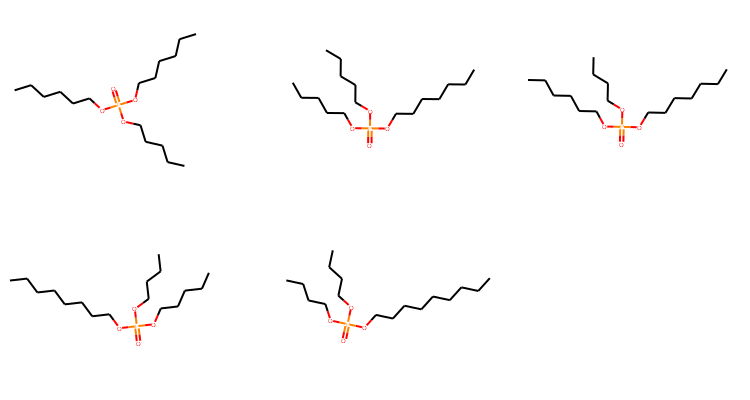

In [71]:
#atmospheric halflife only relevant, when compounds partition to air. 
#With Henry law const <10-5, compounds are considered non-volatile 
#https://www.epa.gov/pesticide-science-and-assessing-pesticide-risks/guidance-reporting-environmental-fate-and-transport#I_A_one

#Filter out all compounds with high henry law const and check atmosheric halflives
print(len(BigDF))
listsmi=[]
for index,row in BigDF.iterrows():
    if BigDF['Bond est henry'][index] >= 1e-5:
        listsmi.append(BigDF['SMILES'][index])
        print(BigDF['Bond est henry'][index])
        print(BigDF['atmthalf'][index])
        if BigDF['atmthalf'][index]>=2:
            print('hazardous compound:', BigDF['SMILES'])
print('These chemicals are not classified as non-volatile, none of them has a long atmospheric halflife:')
drawsmileslist(listsmi)

Text(0.5, 1.0, 'Density plot of octanol-air partition coefficient')

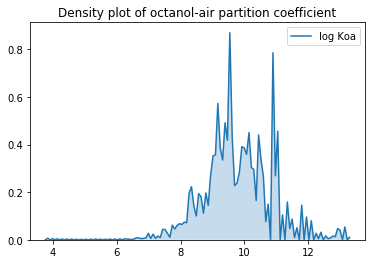

In [72]:
sns.kdeplot(BigDF[BigDF['log Koa']>0]['log Koa'], shade=True, bw=0.001)
plt.title('Density plot of octanol-air partition coefficient')
#plt.xlim(-1000,20)

In [73]:
print('Highest Bioconcentration factor:',BigDF['BCF'].max())
#A bit weird, as logKow shows broader range and is basis for BCF estimation...

Highest Bioconcentration factor: 40.48


### Desirability functions


Functions that describe the relationship between the property value (x-axis) and desirability (y-axis, 0-1). These are later use to score all molecules according to their property.


In [74]:
Figuredir = "C:\\Users\\Hannah\\Documents\\Master UvA\\master project\\OMG\\figures"
os.chdir(Figuredir)
os.getcwd()

'C:\\Users\\Hannah\\Documents\\Master UvA\\master project\\OMG\\figures'

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

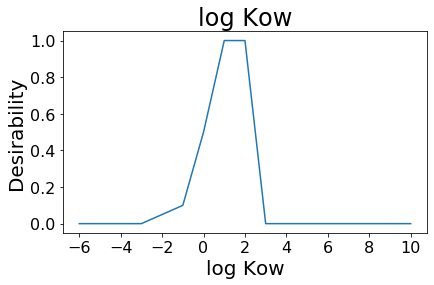

In [75]:
#use these points to design the desirability curve:
logKow_desirability_points = [{"x": -6, "y": 0},{"x": -3, "y": 0},{"x": -1, "y": 0.1},{"x": 0, "y": 0.5}, {"x": 1, "y": 1}, 
                       {"x": 2.0, "y": 1.0}, {"x": 3.0, "y": 0},{"x": 10, "y": 0.0} ]
logKow_desirability = pd.DataFrame(logKow_desirability_points)
#plt.plot(logKow_desirability['x'],logKow_desirability['y'])
plt.xlabel('log Kow',fontsize=20)
plt.ylabel('Desirability',fontsize=20)
plt.title('log Kow', fontsize=24)
f_logKow = interp1d(logKow_desirability['x'],logKow_desirability['y'], kind='linear')
#plt.plot(logKow_desirability['x'],logKow_desirability['y'])
plt.plot(logKow_desirability['x'],f_logKow(logKow_desirability['x']))
plt.tight_layout()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.savefig('logKow', dpi=1800)

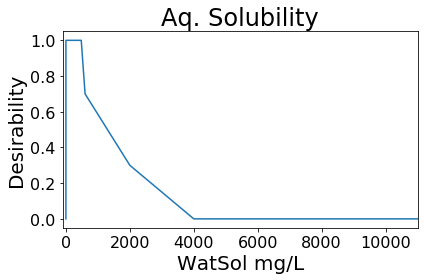

In [76]:
#similar solubility to tibp (475.57) no, lower solubility better
WatSol_desirability_points = [{"x": 0, "y": 0},{"x": 1, "y": 1},{"x": 50, "y": 1},
                              {"x": 480, "y": 1},{"x": 600, "y": 0.7},{"x": 2000, "y": 0.3},
                              {"x": 4000, "y": 0.},{"x": 10000, "y": 0},{"x": 1000000, "y": 0} ]

WatSol_desirability = pd.DataFrame(WatSol_desirability_points)
plt.xlabel('WatSol mg/L', fontsize=20)
plt.ylabel('Desirability', fontsize=20)
plt.title('Aq. Solubility', fontsize=24)
f_WatSol = interp1d(WatSol_desirability['x'],WatSol_desirability['y'], kind='linear')
plt.xlim(-100,11000)
plt.plot(WatSol_desirability['x'],WatSol_desirability['y'])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
#plt.savefig('Aq Solubility', dpi=1800)

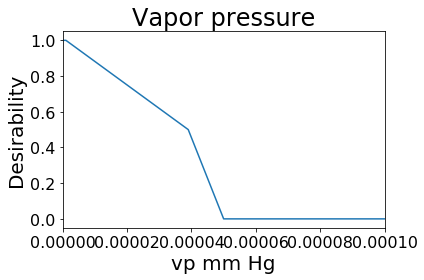

In [77]:
#≤ 9.98 x 10-7 mmHg/Torr: non-volatile, https://www.epa.gov/pesticide-science-and-assessing-pesticide-risks/guidance-reporting-environmental-fate-and-transport#I_B_one
#Higher vapor pressures and high evaporation rates also lead to lower flash points and higher flammability. ≥ 3.90 x 10-5
vp_desirability_points = [{"x": 0, "y": 1},{"x": (9.98E-7), "y": 1},{"x": (3.9E-5), "y": 0.5},
                          {"x": (5.0E-5), "y": 0}, {"x": (0.030), "y": 0} ]

vp_desirability = pd.DataFrame(vp_desirability_points)
plt.xlabel('vp mm Hg', fontsize=20)
plt.ylabel('Desirability', fontsize=20)
plt.xlim(0,1E-4)
plt.title('Vapor pressure', fontsize=24)
f_vp = interp1d(vp_desirability['x'],vp_desirability['y'], kind='linear')
plt.plot(vp_desirability['x'],vp_desirability['y'])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
#plt.savefig('vap', dpi=1800)

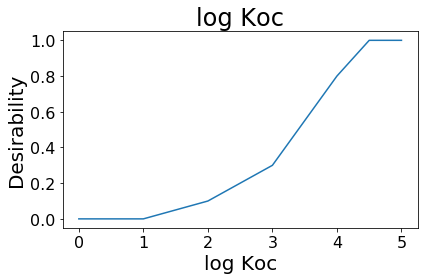

In [78]:
#log Koc < 1 highly mobile,
#log Koc > 5 immobile https://www.chemsafetypro.com/Topics/CRA/Mobility_Classification_of_Chemicals_in_Soil.html
#not too high to prevent sediment adsorption
#https://pubs.rsc.org/en/content/articlepdf/2017/em/c7em00158d
#koc tibp = 1398
#print('Maximum logKoc value in BigDF:',math.log(BigDF['Koc'].max(),10), '; koc =' , BigDF['Koc'].max())
koc_desirability_points = [{"x": 0, "y": 0},{"x": 1, "y": 0},{"x": 2, "y": 0.1},
                           {"x": 3, "y": 0.3},
                          {"x":4, "y": 0.8} ,{"x":4.5, "y": 1},
                           {"x":5, "y": 1} ]

koc_desirability = pd.DataFrame(koc_desirability_points)
plt.xlabel('log Koc', fontsize=20)
plt.ylabel('Desirability', fontsize=20)
plt.title('log Koc', fontsize=24)
f_koc = interp1d(koc_desirability['x'],koc_desirability['y'], kind='linear')
plt.plot(koc_desirability['x'],koc_desirability['y'])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
#plt.savefig('logKoc', dpi=1800)

0.5186
1.6567
0.9692
1.0
3.2513
3.7969
4.0061
4.8266
0.5
1.1535
0.1726
0.9806
0.3307
1.9981


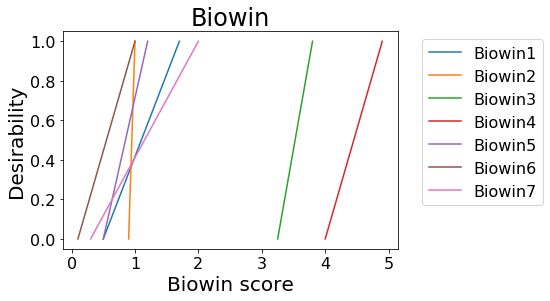

In [79]:
print(BigDF['Biowin1'].min())
print(BigDF['Biowin1'].max())
print(BigDF['Biowin2'].min())
print(BigDF['Biowin2'].max())
print(BigDF['Biowin3'].min())
print(BigDF['Biowin3'].max())
print(BigDF['Biowin4'].min())
print(BigDF['Biowin4'].max())
print(BigDF['Biowin5'].min())
print(BigDF['Biowin5'].max())
print(BigDF['Biowin6'].min())
print(BigDF['Biowin6'].max())
print(BigDF['Biowin7'].min())
print(BigDF['Biowin7'].max())
##1
biowin1_desirability_points = [{"x": 0.5, "y": 0},{"x": 1.7, "y": 1}]

biowin1_desirability = pd.DataFrame(biowin1_desirability_points)
f_biowin1 = interp1d(biowin1_desirability['x'],biowin1_desirability['y'], kind='linear')
plt.plot(biowin1_desirability['x'],biowin1_desirability['y'], label='Biowin1')

##2
biowin2_desirability_points = [{"x": 0.9, "y": 0},{"x": 1.0, "y": 1}]

biowin2_desirability = pd.DataFrame(biowin2_desirability_points)
f_biowin2 = interp1d(biowin2_desirability['x'],biowin2_desirability['y'], kind='linear')
plt.plot(biowin2_desirability['x'],biowin2_desirability['y'], label='Biowin2')

##3
biowin3_desirability_points = [{"x": 3.25, "y": 0},{"x": 3.8, "y": 1}]

biowin3_desirability = pd.DataFrame(biowin3_desirability_points)
f_biowin3 = interp1d(biowin3_desirability['x'],biowin3_desirability['y'], kind='linear')
plt.plot(biowin3_desirability['x'],biowin3_desirability['y'], label='Biowin3')

##4
biowin4_desirability_points = [{"x": 4.0, "y": 0},{"x": 4.9, "y": 1}]

biowin4_desirability = pd.DataFrame(biowin4_desirability_points)
f_biowin4 = interp1d(biowin4_desirability['x'],biowin4_desirability['y'], kind='linear')
plt.plot(biowin4_desirability['x'],biowin4_desirability['y'], label='Biowin4')

##5
biowin5_desirability_points = [{"x": 0.5, "y": 0},{"x": 1.2, "y": 1}]

biowin5_desirability = pd.DataFrame(biowin5_desirability_points)
f_biowin5 = interp1d(biowin5_desirability['x'],biowin5_desirability['y'], kind='linear')
plt.plot(biowin5_desirability['x'],biowin5_desirability['y'], label='Biowin5')

##6
biowin6_desirability_points = [{"x": 0.1, "y": 0},{"x": 1.0, "y": 1}]

biowin6_desirability = pd.DataFrame(biowin6_desirability_points)
f_biowin6 = interp1d(biowin6_desirability['x'],biowin6_desirability['y'], kind='linear')
plt.plot(biowin6_desirability['x'],biowin6_desirability['y'], label = 'Biowin6')

##7
biowin7_desirability_points = [{"x": 0.3, "y": 0},{"x": 2, "y": 1}]

biowin7_desirability = pd.DataFrame(biowin7_desirability_points)
f_biowin7 = interp1d(biowin7_desirability['x'],biowin7_desirability['y'], kind='linear')

plt.plot(biowin7_desirability['x'],biowin7_desirability['y'], label='Biowin7')

plt.xlabel('Biowin score', fontsize=20)
plt.ylabel('Desirability', fontsize=20)
plt.title('Biowin', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1))
#plt.savefig('Biowin', dpi=1800,bbox_inches='tight')

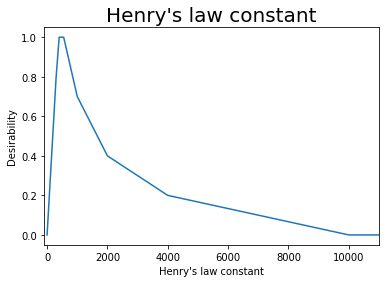

In [80]:
#Chemical substances with high HLC values will volatilize from water into air and be distributed over a large area.
#Chemical substances with low HLC values tend to persist in water and may be adsorbed onto soil or sediment.
#this function was ultimately not used
henry_desirability_points = [{"x": 0, "y": 0},{"x": 300, "y": 0.8},{"x": 400, "y": 1},{"x": 550, "y": 1},
                              {"x": 700, "y": 0.9},{"x": 1000, "y": 0.7},{"x": 2000, "y": 0.4},{"x": 4000, "y": 0.2},
                              {"x": 10000, "y": 0},{"x": 1000000, "y": 0} ]

henry_desirability = pd.DataFrame(henry_desirability_points)
plt.xlabel('Henry\'s law constant')
plt.ylabel('Desirability')
plt.title('Henry\'s law constant', fontsize=20)
f_henry = interp1d(henry_desirability['x'],henry_desirability['y'], kind='linear')
plt.xlim(-100,11000)
plt.plot(henry_desirability['x'],henry_desirability['y'])

In [81]:

#for every property, write a desirability function
#write a function that assigns a desirability score to every molecule, that is to every row of df, 
#for every property
#this function adds the calculated score to the overall score in the desirability_score column
#and creates another column for the property specific desirability score
#order the dataframe according to desirability score
    
def AddOneDesirabilityScore(df, des_f, column, weight):
    '''Takes values from colum in df and apllies desirability function on it, then increases value in 
    column Desirability score of df by this value multiplied by the weight given 
    to this property in the arguments'''
    des_score = dict()
    for index,row in df.iterrows():
        des_row = des_f(df[column][index])
        df['Desirability score'][index] = df['Desirability score'][index].astype(float) + (weight * np.float(des_row))
    return df

def AddDesirabilityScore(df, des_f, column, weight):
    '''Takes values from colum in df and apllies desirability function on it, then increases value in 
    column Desirability score of df by this value multiplied by the weight given 
    to this property in the arguments'''
    des_columnname= str(column + ' Des score')
    df[des_columnname] = float(0)
    des_score = dict()
    for index,row in df.iterrows():
        des_row = des_f(df[column][index])
        df[des_columnname][index] = df[des_columnname][index].astype(float) + (weight * np.float(des_row))
    return df
        
def LogKowDesirabilityScore(df, weight=1):
    '''Applies log Kow desirability function to increase Desirability score'''
    newdf = AddDesirabilityScore(df, f_logKow, 'log Kow', weight)
    newdf = AddOneDesirabilityScore(df, f_logKow, 'log Kow', weight)
    return newdf

def Biowin1DesirabilityScore(df, weight=1):
    '''Applies biowin desirability function to increase Desirability score'''
    newdf = AddDesirabilityScore(df, f_biowin1, 'Biowin1', weight)
    newdf = AddOneDesirabilityScore(df, f_biowin1, 'Biowin1', weight)
    return newdf
def Biowin2DesirabilityScore(df, weight=1):
    '''Applies biowin desirability function to increase Desirability score'''
    newdf = AddDesirabilityScore(df, f_biowin2, 'Biowin2', weight)
    newdf = AddOneDesirabilityScore(df, f_biowin2, 'Biowin2', weight)
    return newdf
def Biowin3DesirabilityScore(df, weight=1):
    '''Applies biowin desirability function to increase Desirability score'''
    newdf = AddDesirabilityScore(df, f_biowin3, 'Biowin3', weight)
    newdf = AddOneDesirabilityScore(df, f_biowin3, 'Biowin3', weight)
    return newdf
def Biowin4DesirabilityScore(df, weight=1):
    '''Applies biowin desirability function to increase Desirability score'''
    newdf = AddDesirabilityScore(df, f_biowin4, 'Biowin4', weight)
    newdf = AddOneDesirabilityScore(df, f_biowin4, 'Biowin4', weight)
    return newdf
def Biowin5DesirabilityScore(df, weight=1):
    '''Applies biowin desirability function to increase Desirability score'''
    newdf = AddDesirabilityScore(df, f_biowin5, 'Biowin5', weight)
    newdf = AddOneDesirabilityScore(df, f_biowin5, 'Biowin5', weight)
    return newdf
def Biowin6DesirabilityScore(df, weight=1):
    '''Applies biowin desirability function to increase Desirability score'''
    newdf = AddDesirabilityScore(df, f_biowin6, 'Biowin6', weight)
    newdf = AddOneDesirabilityScore(df, f_biowin6, 'Biowin6', weight)
    return newdf
def Biowin7DesirabilityScore(df, weight=1):
    '''Applies biowin desirability function to increase Desirability score'''
    newdf = AddDesirabilityScore(df, f_biowin7, 'Biowin7', weight)
    newdf = AddOneDesirabilityScore(df, f_biowin7, 'Biowin7', weight)
    return newdf

def mpDesirabilityScore(df, weight=1):
    '''Applies mp desirability function to increase Desirability score'''
    newdf = AddDesirabilityScore(df, f_mp, 'mp degC', weight)
    newdf = AddOneDesirabilityScore(df, f_mp, 'mp degC', weight)
    return newdf

def vpDesirabilityScore(df, weight=1):
    '''Applies vp desirability function to increase Desirability score'''
    newdf = AddDesirabilityScore(df, f_vp, 'vp mmHg', weight)
    newdf = AddOneDesirabilityScore(df, f_vp, 'vp mmHg', weight)
    return newdf

def WatSolDesirabilityScore(df, weight=1):
    '''Applies WatSol desirability function to increase Desirability score'''
    newdf = AddDesirabilityScore(df, f_WatSol, 'WatSol mg/L', weight)
    newdf = AddOneDesirabilityScore(df, f_WatSol, 'WatSol mg/L', weight)
    return newdf

def logkocDesirabilityScore(df, weight=1):
    '''Applies WatSol desirability function to increase Desirability score'''
    newdf = AddDesirabilityScore(df, f_koc, 'log koc', weight)
    newdf = AddOneDesirabilityScore(df, f_koc, 'log koc', weight)
    return newdf


   


### Application of desirability functions

In [82]:
#reset
BigDF['Desirability score'] = float(0)
#check
BigDF['Desirability score'].max()

0.0

In [83]:
BigDF = LogKowDesirabilityScore(BigDF, 2)

C:\Users\Hannah\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Hannah\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [84]:
BigDF = Biowin1DesirabilityScore(BigDF, 1/7)
BigDF = Biowin2DesirabilityScore(BigDF, 1/7)
BigDF = Biowin3DesirabilityScore(BigDF, 1/7)
BigDF = Biowin4DesirabilityScore(BigDF, 1/7)
BigDF = Biowin5DesirabilityScore(BigDF, 1/7)
BigDF = Biowin6DesirabilityScore(BigDF, 1/7)
BigDF = Biowin7DesirabilityScore(BigDF, 1/7)

C:\Users\Hannah\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Hannah\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [85]:
BigDF = vpDesirabilityScore(BigDF, 1)

C:\Users\Hannah\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Hannah\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [86]:
BigDF = WatSolDesirabilityScore(BigDF, 1)

C:\Users\Hannah\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Hannah\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [87]:
BigDF = logkocDesirabilityScore(BigDF, 1)

C:\Users\Hannah\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Hannah\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [88]:
BigDF['Desirability rank'] = BigDF['Desirability score'].rank(ascending=False).astype(int) #method='dense',
#BigDF['Desirability rank'] = BigDF['Desirability rank']
#BigDF[['Desirability score','Desirability rank']][:1000]
#BigDF[BigDF['Desirability rank']==1]
BigDF['Desirability rank'].max()

31292

##  Top 500 molecules according to desirability score

These are the top 50 molecules according to the combined desirability score:


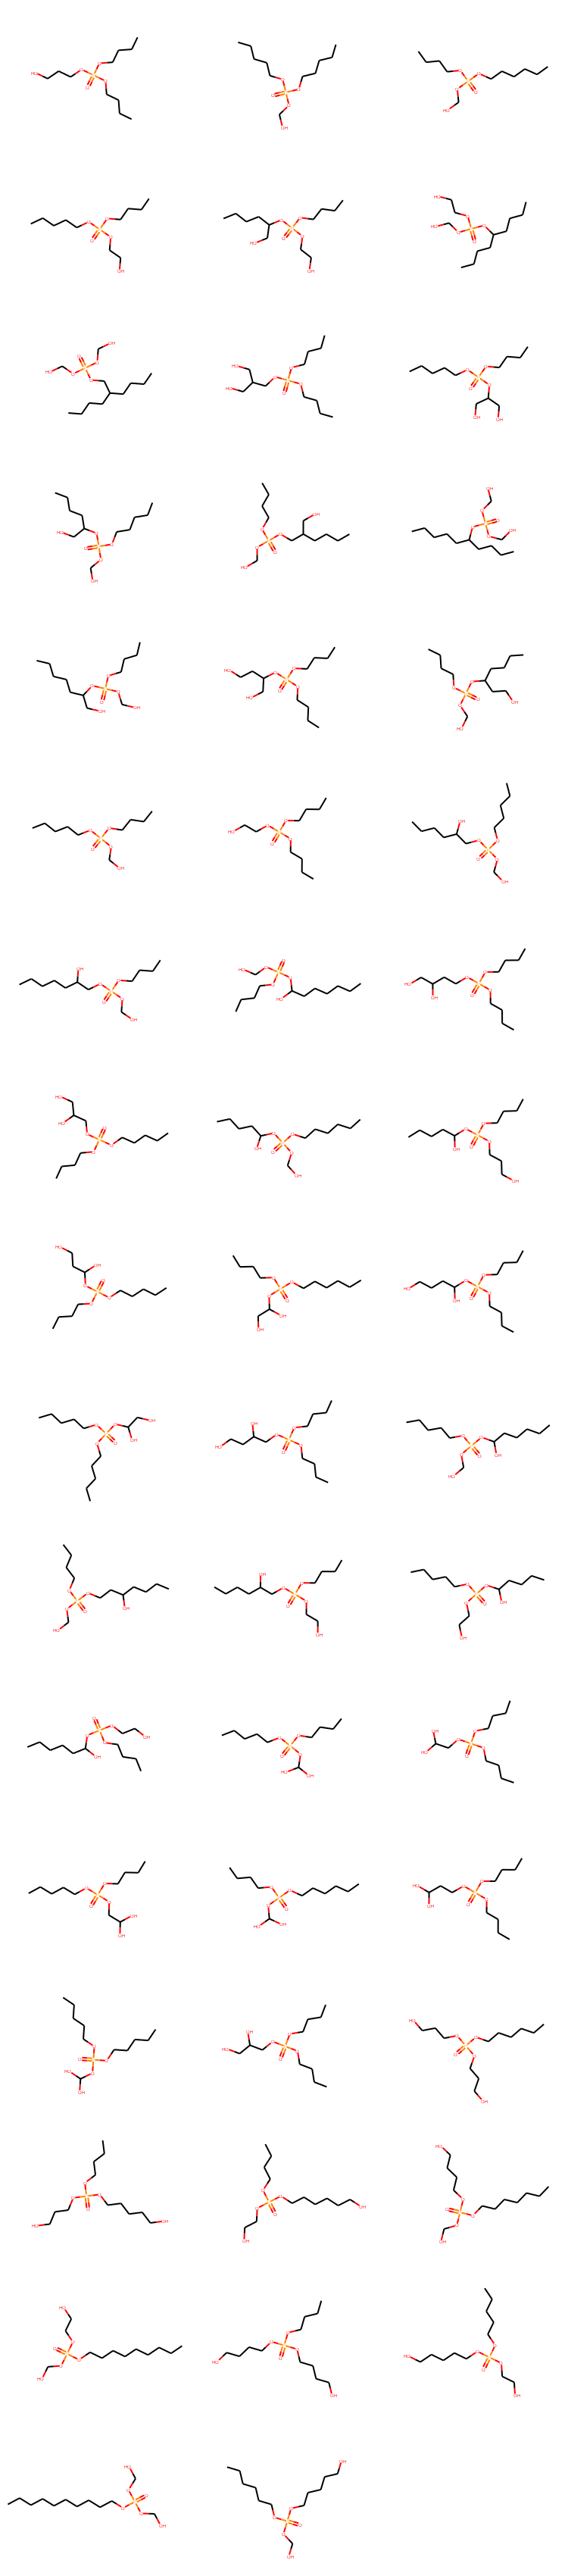

In [90]:
sortedBig = BigDF.sort_values('Desirability score', ascending=False) #sort according to descending desirability score
sortedBigDF = sortedBig.reset_index()
BigDFscoretop500 = sortedBig.head(500)
print('These are the top 50 molecules according to the combined desirability score:')
drawsmileslist(BigDFscoretop500['SMILES'])

### Density plots

To illustrate the shift of property value distribution after the application of the desirability plots, kernel densitiy plots of the distribution of properties in the whole dataset and the top 500 compounds were created, overlayed with the desirability function of the respectie property.

By tuning the bandwidth (bw) argument of the kernel density plots the curve gets more detailed (lower bw), i.e. closer to the data.

C:\Users\Hannah\anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


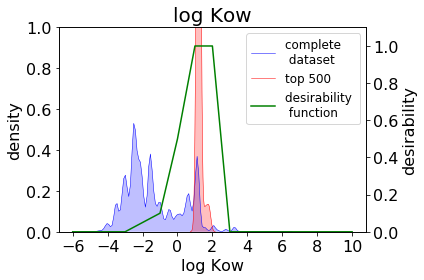

In [91]:
plt.title('log Kow', fontsize=20)
ax = plt.subplot(111)
ax2 = ax.twinx()
ax2.set_ylim(0,1.1)
ax.set_ylim(0,1)

sns.kdeplot(BigDF['log Kow'], shade=True, color="b", linewidth=0.5,bw=0.1, ax=ax, 
                 label='complete \n dataset')
sns.kdeplot(BigDFscoretop500['log Kow'], shade=True, color="r", linewidth=0.5,
                 bw=0.1, ax=ax, label='top 500')
ax2.plot(logKow_desirability['x'],f_logKow(logKow_desirability['x']), color='g',
             label='desirability \n function')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=12)
ax.legend().set_visible(False)

ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)

ax.xaxis.set_ticks(np.arange(-6, 12, 2))
ax.set_xlabel('log Kow',fontsize=16)

ax.set_ylabel('density',fontsize=16)
ax2.set_ylabel('desirability',fontsize=16)
plt.tight_layout()
#plt.savefig('logKowDens', dpi=1800)

C:\Users\Hannah\anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


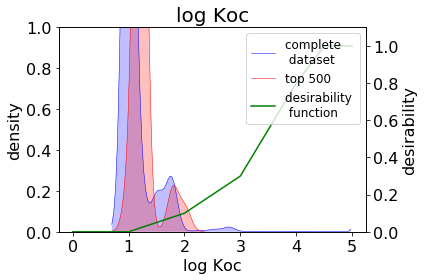

In [92]:
plt.title('log Koc', fontsize=20)
ax = plt.subplot(111)
ax2 = ax.twinx()
ax2.set_ylim(0,1.1)
ax.set_ylim(0,1)

sns.kdeplot(BigDF['log koc'], shade=True, color="b", linewidth=0.5,bw=0.1, ax=ax, 
                 label='complete \n dataset')
sns.kdeplot(BigDFscoretop500['log koc'], shade=True, color="r", linewidth=0.5,
                 bw=0.1, ax=ax, label='top 500')
ax2.plot(koc_desirability['x'],f_koc(koc_desirability['x']), color='g',
             label='desirability \n function')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=12)
ax.legend().set_visible(False)

ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)

#ax.xaxis.set_ticks(np.arange(-, 12, 2))
ax.set_xlabel('log Koc',fontsize=16)

ax.set_ylabel('density',fontsize=16)
ax2.set_ylabel('desirability',fontsize=16)
plt.tight_layout()
#plt.savefig('logKocDens', dpi=1800)

C:\Users\Hannah\anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


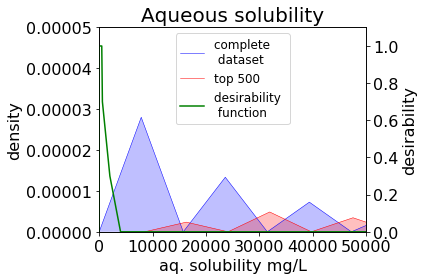

In [93]:
plt.title('Aqueous solubility', fontsize=20)
ax = plt.subplot(111)
ax2 = ax.twinx()
ax2.set_ylim(0,1.1)
ax.set_ylim(0,0.00005)
ax.set_xlim(0,50000)

sns.kdeplot(BigDF['WatSol mg/L'], shade=True, color="b", linewidth=0.5,bw=0.00001, ax=ax, 
                 label='complete \n dataset')
sns.kdeplot(BigDFscoretop500['WatSol mg/L'], shade=True, color="r", linewidth=0.5,
                 bw=0.00001, ax=ax, label='top 500')
ax2.plot(WatSol_desirability['x'],f_WatSol(WatSol_desirability['x']), color='g',
             label='desirability \n function')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper center', fontsize=12)
ax.legend().set_visible(False)

ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)

#ax.xaxis.set_ticks([0,300000,600000,900000])
ax.set_xlabel('aq. solubility mg/L',fontsize=16)

ax.set_ylabel('density',fontsize=16)
ax2.set_ylabel('desirability',fontsize=16)
plt.tight_layout()
#plt.savefig('AqSolDens2', dpi=1800)

C:\Users\Hannah\anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


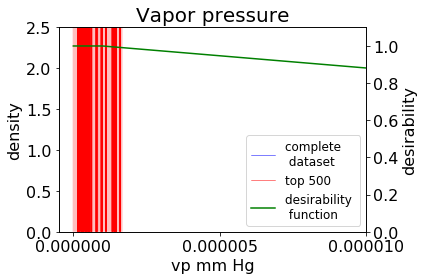

In [94]:
plt.title('Vapor pressure', fontsize=20)
ax = plt.subplot(111)
ax2 = ax.twinx()
ax2.set_ylim(0,1.1)
ax.set_ylim(0,2.5)
ax.set_xlim(-5e-7,1e-5)

sns.kdeplot(BigDF['vp mmHg'], shade=True, color="b", linewidth=0.5,bw=0.00000001, ax=ax, 
                 label='complete \n dataset')
sns.kdeplot(BigDFscoretop500['vp mmHg'], shade=True, color="r", linewidth=0.5,
                 bw=0.00000001, ax=ax, label='top 500')
ax2.plot(vp_desirability['x'],f_vp(vp_desirability['x']), color='g',
             label='desirability \n function')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower right', fontsize=12)
ax.legend().set_visible(False)

ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)

ax.xaxis.set_ticks([0,5e-6,1e-5])
ax.set_xlabel('vp mm Hg',fontsize=16)

ax.set_ylabel('density',fontsize=16)
ax2.set_ylabel('desirability',fontsize=16)
plt.tight_layout()
#plt.savefig('vp_2', dpi=1800)

C:\Users\Hannah\anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


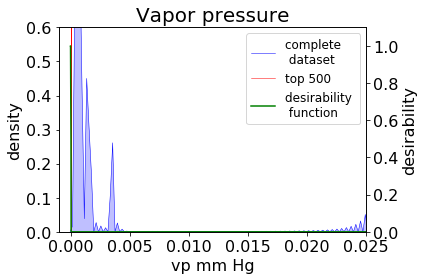

In [95]:
plt.title('Vapor pressure', fontsize=20)
ax = plt.subplot(111)
ax2 = ax.twinx()
ax2.set_ylim(0,1.1)
ax.set_ylim(0,0.6)
ax.set_xlim(-0.001,0.025)

sns.kdeplot(BigDF['vp mmHg'], shade=True, color="b", linewidth=0.5,bw=0.00001, ax=ax, 
                 label='complete \n dataset')
sns.kdeplot(BigDFscoretop500['vp mmHg'], shade=True, color="r", linewidth=0.5,
                 bw=0.00000001, ax=ax, label='top 500')
ax2.plot(vp_desirability['x'],f_vp(vp_desirability['x']), color='g',
             label='desirability \n function')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=12)
ax.legend().set_visible(False)

ax.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)

#ax.xaxis.set_ticks([0,5e-6,1e-5])
ax.set_xlabel('vp mm Hg',fontsize=16)

ax.set_ylabel('density',fontsize=16)
ax2.set_ylabel('desirability',fontsize=16)
plt.tight_layout()
#plt.savefig('vp_3', dpi=1800)

In [96]:
BigDFscoretop500['vp mmHg'].mean()

1.0746203999999832e-07

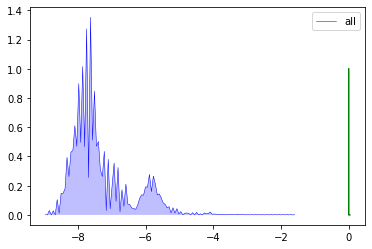

In [97]:
#overall distribution of vapor pressures
sns.kdeplot(np.log10(BigDF['vp mmHg']), shade=True, color="b", linewidth=0.5,bw=0.000000001, 
                 label='all')
plt.plot(vp_desirability['x'],f_vp(vp_desirability['x']), color='g',
             label='desirability')
#plt.plot([0.1e-7,1e-6,5e-5,4e-7,3e-8],f_vp([0.1e-7,1e-6,5e-5,4e-7,3e-8]), color='y',
#             label='desirability')
#plt.xlim(-5e-5,1e-3)

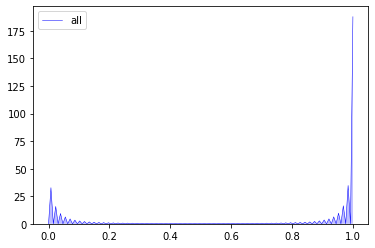

In [98]:
#overall distribution of vapor pressure desirability score.
sns.kdeplot(BigDF['vp mmHg Des score'], shade=True, color="b", linewidth=0.5,bw=0.000000001, 
                 label='all')

In [99]:
#fraction of high desirability
print('>=0.9')
print('WatSol:',len(BigDF[BigDF['WatSol mg/L Des score']>=0.9])/len(BigDF))
print('vp:',len(BigDF[BigDF['vp mmHg Des score']>=0.9])/len(BigDF))
print('logKoc:',len(BigDF[BigDF['log koc Des score']>=0.9])/len(BigDF))
print('log kow:',len(BigDF[BigDF['log Kow Des score']>=0.9])/len(BigDF))
print('>0')
print('WatSol:',len(BigDF[BigDF['WatSol mg/L Des score']>0])/len(BigDF))
print('vp:',len(BigDF[BigDF['vp mmHg Des score']>0])/len(BigDF))
print('logKoc:',len(BigDF[BigDF['log koc Des score']>0])/len(BigDF))
print('log kow:',len(BigDF[BigDF['log Kow Des score']>0])/len(BigDF))
#print('biowin3',len(BigDF[BigDF['Biowin3']==1])/len(BigDF))

>=0.9
WatSol: 0.007254018470584476
vp: 0.9870578084555651
logKoc: 0.0002876042565429968
log kow: 0.24887354999520658
>0
WatSol: 0.01080113763461477
vp: 0.9935129262135302
logKoc: 0.21241172147125556
log kow: 0.8704502604416323


C:\Users\Hannah\anaconda3\lib\site-packages\ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


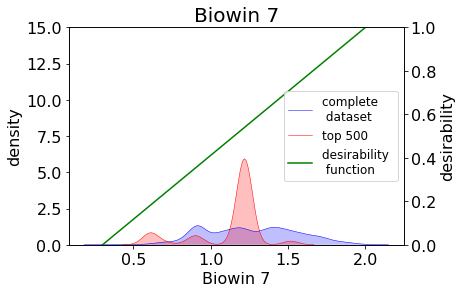

In [100]:
#define functions to plots the biowin distribution
def plotpropdens(title, column, prop_desirability, f_prop ,label1 ='complete dataset', label2='top 1000 \n desirability score',
                label3='Desirability function', BigDF=BigDF, 
                 BigDFscoretop500=BigDFscoretop500 , additional=''):
    '''create a kernel density plot from the specified property'''
    plt.title(title)

    ax = plt.subplot(111)
    ax2 = ax.twinx()
    ax2.set_ylim(0,1)

    sns.kdeplot(BigDF[column], shade=True, color="b", linewidth=0.5,bw=0.0001, ax=ax, 
                     label=label1)
    sns.kdeplot(BigDFscoretop500[column], shade=True, color="r", linewidth=0.5,
                     bw=0.0001, ax=ax, label=label2)
    ax2.plot(prop_desirability['x'],f_prop(prop_desirability['x']), color='g',
                 label=label3)

    # ask matplotlib for the plotted objects and their labels
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    
def plotbiowindens(number, prop_desirability, f_prop ,x_lim=False,x_1=0, x_2=10,
                   y_lim=False,y_1=0, y_2=10,
                  label1 ='complete \n dataset', label2='top 500',
                label3='desirability \n function', BigDF=BigDF, 
                 BigDFscoretop500=BigDFscoretop500 , additional=''):
    '''creates kernel density plot for the specified Biowin model'''
    plt.title('Biowin '+str(number), fontsize=20)

    ax = plt.subplot(111)
    ax2 = ax.twinx()
    ax2.set_ylim(0,1)

    sns.kdeplot(BigDF[('Biowin'+number)], shade=True, color="b", linewidth=0.5,bw=0.05, ax=ax, 
                     label=label1)
    sns.kdeplot(BigDFscoretop500[('Biowin'+number)], shade=True, color="r", linewidth=0.5,
                     bw=0.05, ax=ax, label=label2)
    ax2.plot(prop_desirability['x'],f_prop(prop_desirability['x']), color='g',
                 label=label3)
    # ask matplotlib for the plotted objects and their labels
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='center right', fontsize=12)
    ax.legend().set_visible(False)
    ax.tick_params(labelsize=16)
    ax2.tick_params(labelsize=16)
    ax.set_xlabel(('Biowin '+number),fontsize=16)

    ax.set_ylabel('density',fontsize=16)
    ax2.set_ylabel('desirability',fontsize=16)

   
    if x_lim == True:
        ax.set_xlim(x_1,x_2)
    if y_lim == True:
        ax.set_ylim(y_1,y_2)

plotbiowindens('7', biowin7_desirability,f_biowin7, y_lim=True, y_2=15)
#plotbiowindens('6', biowin6_desirability,f_biowin6, y_lim=True, y_2=15)
#plotbiowindens('5', biowin5_desirability,f_biowin5, y_lim=True, y_2=15) #change legend to lower right
#plotbiowindens('4', biowin4_desirability,f_biowin4, y_lim=True)
#plotbiowindens('3', biowin3_desirability,f_biowin3, y_lim=True, y_2=50)
#plotbiowindens('2', biowin2_desirability,f_biowin2, y_lim=True, y_2=40)
#plotbiowindens('1', biowin1_desirability,f_biowin1, y_lim=True)
#plt.savefig('biowin1Dens', dpi=1800,bbox_inches='tight')
#all values in biowin2 are 1, thus not kde possible

### Stack plots
These stack plots show the contribution of the individual properties to the toal desirability score.

31293


(0, 5000)

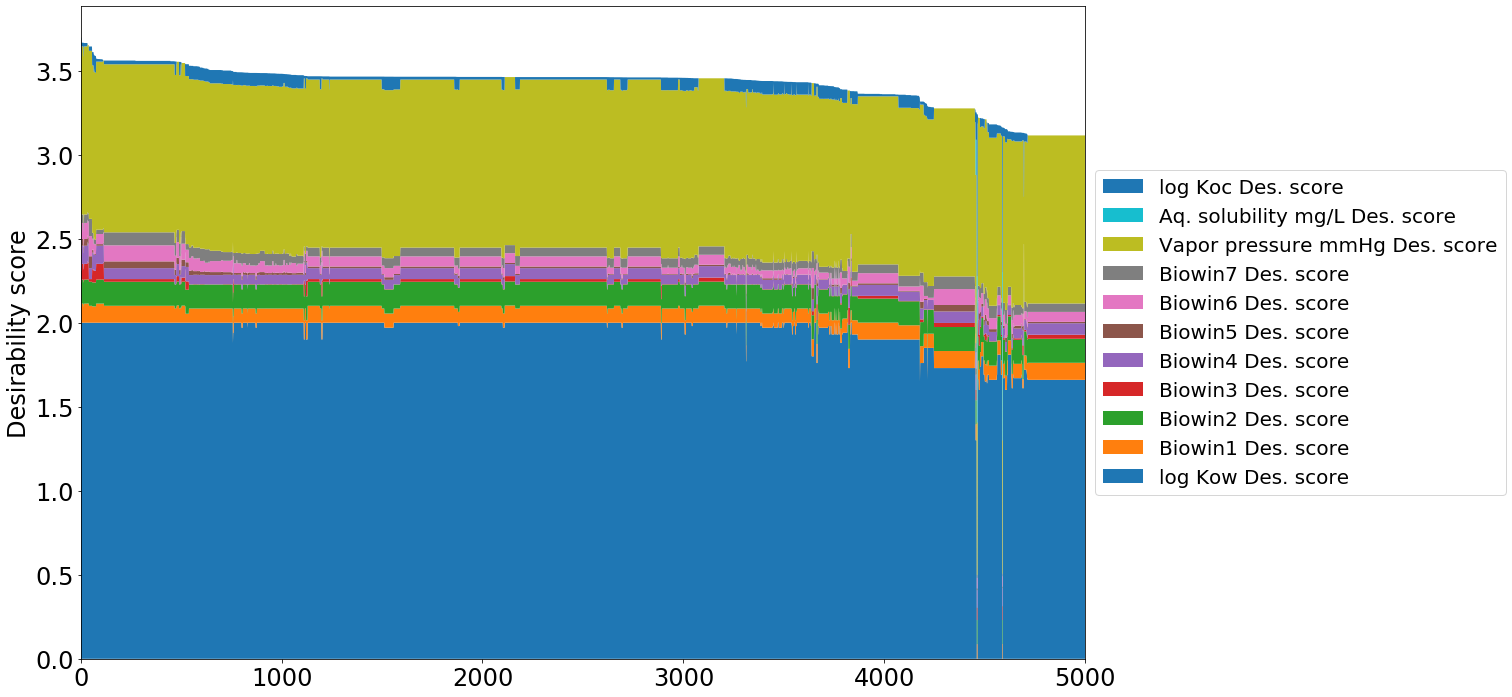

In [110]:
#specify here the df to plot
BigDF2=sortedBigDF#sortedBigDf for sorted configuration
print(len(BigDF2))
fig=plt.figure(figsize=(18, 12), facecolor='w', edgecolor='k')
#x = list(range(31293))
Des_score_labels = ['log Kow Des. score', 'Biowin1 Des. score', 'Biowin2 Des. score',
       'Biowin3 Des. score', 'Biowin4 Des. score', 'Biowin5 Des. score',
       'Biowin6 Des. score', 'Biowin7 Des. score', 'Vapor pressure mmHg Des. score',
       'Aq. solubility mg/L Des. score', 'log Koc Des. score']
#Des_score_labels = Des_score_labels[::-1]
plt.stackplot(BigDF2.index,BigDF2['log Kow Des score'], BigDF2['Biowin1 Des score'], BigDF2['Biowin2 Des score'],
       BigDF2['Biowin3 Des score'], BigDF2['Biowin4 Des score'], BigDF2['Biowin5 Des score'],
       BigDF2['Biowin6 Des score'], BigDF2['Biowin7 Des score'], BigDF2['vp mmHg Des score'],
       BigDF2['WatSol mg/L Des score'],BigDF2['log koc Des score'], labels=Des_score_labels)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Desirability score', fontsize=24)
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
plt.legend(reversed(plt.legend().legendHandles), reversed(Des_score_labels),loc='center left', 
           bbox_to_anchor=(1, 0.5), fontsize=20)
plt.xlim(0,5000)
#plt.ylim(2,4)
#plt.savefig('stackall_sorted_kow1', dpi=100,bbox_inches='tight')


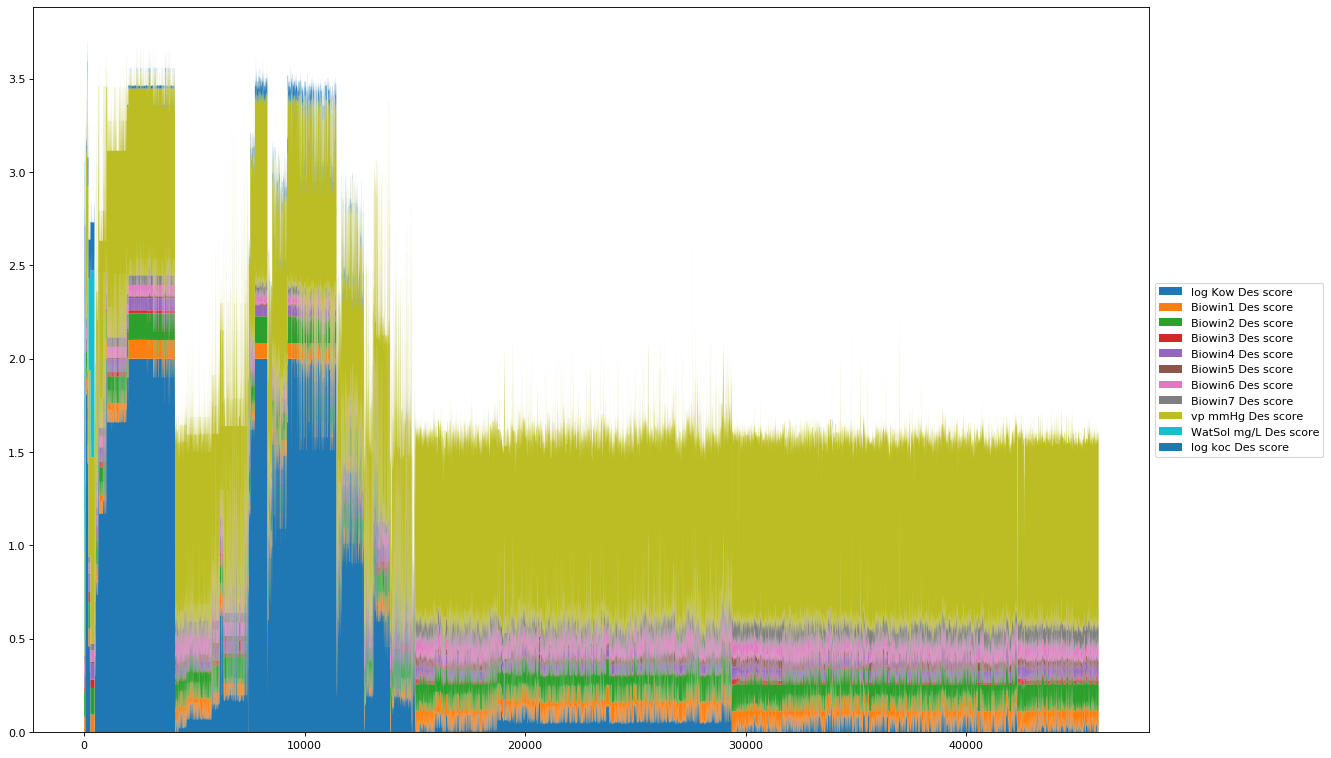

In [102]:
#print(BigDF.columns)
fig=plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
x = list(range(46013))
Des_score_labels = ['log Kow Des score', 'Biowin1 Des score', 'Biowin2 Des score',
       'Biowin3 Des score', 'Biowin4 Des score', 'Biowin5 Des score',
       'Biowin6 Des score', 'Biowin7 Des score', 'vp mmHg Des score',
       'WatSol mg/L Des score', 'log koc Des score']
#Des_score_labels = Des_score_labels[::-1]
plt.stackplot(BigDF.index,BigDF['log Kow Des score'], BigDF['Biowin1 Des score'], BigDF['Biowin2 Des score'],
       BigDF['Biowin3 Des score'], BigDF['Biowin4 Des score'], BigDF['Biowin5 Des score'],
       BigDF['Biowin6 Des score'], BigDF['Biowin7 Des score'], BigDF['vp mmHg Des score'],
       BigDF['WatSol mg/L Des score'],BigDF['log koc Des score'], labels=Des_score_labels)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Influence of log Kow on desirability score
This plot was created to show that the total desirbaility score is not solely dependent on the logKow

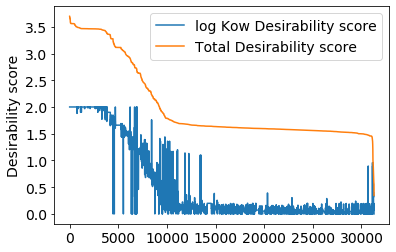

In [103]:
plt.plot(sortedBigDF['log Kow Des score'])
plt.plot(sortedBigDF['Desirability score'])
plt.legend(['log Kow Desirability score','Total Desirability score'], fontsize=14)
plt.ylabel('Desirability score', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig('logKowDesvstotaldes', dpi=1800)

## Identified targets in the dataset

The structures of the top scoring compounds were searched manually for synthetically accesible and chemically sane molecules. 
Two candidates were selected, these went into the experimental stage. Here, their data is retrieved from the dataset to examine their predicte properties more closely.

In [104]:
#define SMILES codes of the target molecules

tibp = 'O=P(OCC(C)C)(OCC(C)C)OCC(C)C' #original compound
target1 = 'CCCCOP(OCCCC)(OCCO)=O' 
target2 = 'O=P1(OCC(O1)CCCCCC)OCCO'

Original compound TiBP; Targets 1 and 2:


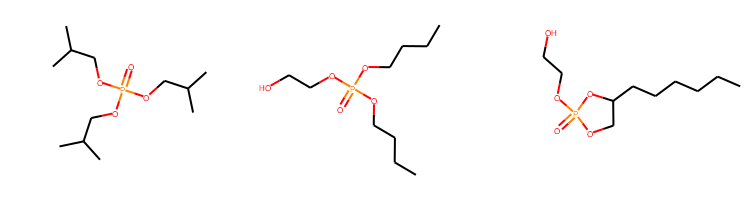

In [105]:
print('Original compound TiBP; Targets 1 and 2:')
show_mol_grid([Chem.MolFromSmiles(tibp),Chem.MolFromSmiles(target1),Chem.MolFromSmiles(target2)])

In [106]:
def showSMIrow(smiles, BigDF = BigDF):
    smii = Chem.MolToSmarts(Chem.MolFromSmiles(smiles))
    return BigDF[BigDF['Smarts']== smii]

def showSMIprops(smiles, BigDF = BigDF):
    smii =Chem.MolToInchi(Chem.MolFromSmiles(smiles))
    smii_props = BigDF[BigDF['Inchi']== smii]
    return smii_props[['SMILES','Desirability score','Desirability rank','bp degC','mp degC','vp mmHg',
                 'WatSol mg/L','WSol mg/L','log Kow','log koc','kOH','Bond est henry','Biowin1', 'Biowin2', 'Biowin3', 'Biowin4', 'Biowin5', 'Biowin6', 'Biowin7']]
def showSMIpropsall(smiles, BigDF = BigDF):
    smii =Chem.MolToInchi(Chem.MolFromSmiles(smiles))
    smii_props = BigDF[BigDF['Inchi']== smii]
    return smii_props

In [107]:
target1props = showSMIpropsall(target1, BigDF)
target1props

,kOH,SMILES,Bond est henry,Koc,bp degC,mp degC,vp mmHg,log WatSol mol/L,WatSol mg/L,WSol mg/L,...,Biowin2 Des score,Biowin3 Des score,Biowin4 Des score,Biowin5 Des score,Biowin6 Des score,Biowin7 Des score,vp mmHg Des score,WatSol mg/L Des score,log koc Des score,Desirability rank
135,8.027160e-11,CCCCOP(=O)(OCCO)OCCCC,6.620000e-11,62.02,348.3,82.35,0.000002,-0.9614,27790.0,4888.0,...,0.142857,0.077325,0.097429,0.034224,0.093476,0.051193,0.991422,0.0,0.079253,16


In [108]:
target2props = showSMIpropsall(target2, BigDF)
target2props

,kOH,SMILES,Bond est henry,Koc,bp degC,mp degC,vp mmHg,log WatSol mol/L,WatSol mg/L,WSol mg/L,...,Biowin2 Des score,Biowin3 Des score,Biowin4 Des score,Biowin5 Des score,Biowin6 Des score,Biowin7 Des score,vp mmHg Des score,WatSol mg/L Des score,log koc Des score,Desirability rank
7940,8.826004e-11,CCCCCCC1COP(=O)(OCCO)O1,2.920000e-11,63.35,356.7,84.81,8.960000e-07,-0.9625,27502.0,7230.0,...,0.142857,0.000987,0.05519,0.031837,0.083349,0.075622,1.0,0.0,0.080175,472


In [109]:
#save to .txt
#target1props.to_csv('C:\\Users\\Hannah\\Documents\\Master UvA\\master project\\OMG\\selection\\target1_props_all.txt', 
 #                              header=True, index=True, sep='\t', mode='a')